In [1]:
import os
from pathlib import Path
from functools import partial
from typing import Any, cast

import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.datasets.cookie_ad import CookieAD
from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import InferencePreprocessing

DATASET_DIR = Path(os.environ["COOKIE_DATASET_DIR"])
SAVED_MODEL = Path(os.environ["COOKIE_SAVED_MODEL"])
HISTORY_FILE = Path(os.environ["COOKIE_HISTORY_FILE"])

<Axes: xlabel='epoch'>

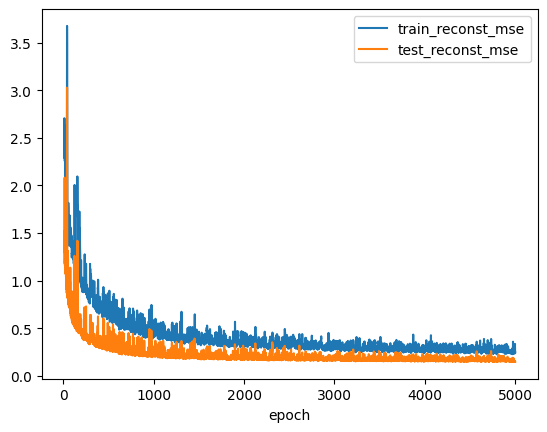

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 10].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: torch.Tensor) -> torch.Tensor:
    return torch.tensor(0) if label == 0 else torch.tensor(1)

create_ds = partial(
        CookieAD,
        dataset_dir=DATASET_DIR,
        sample_transform=InferencePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
  )
  (decoder): Decoder(
    (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

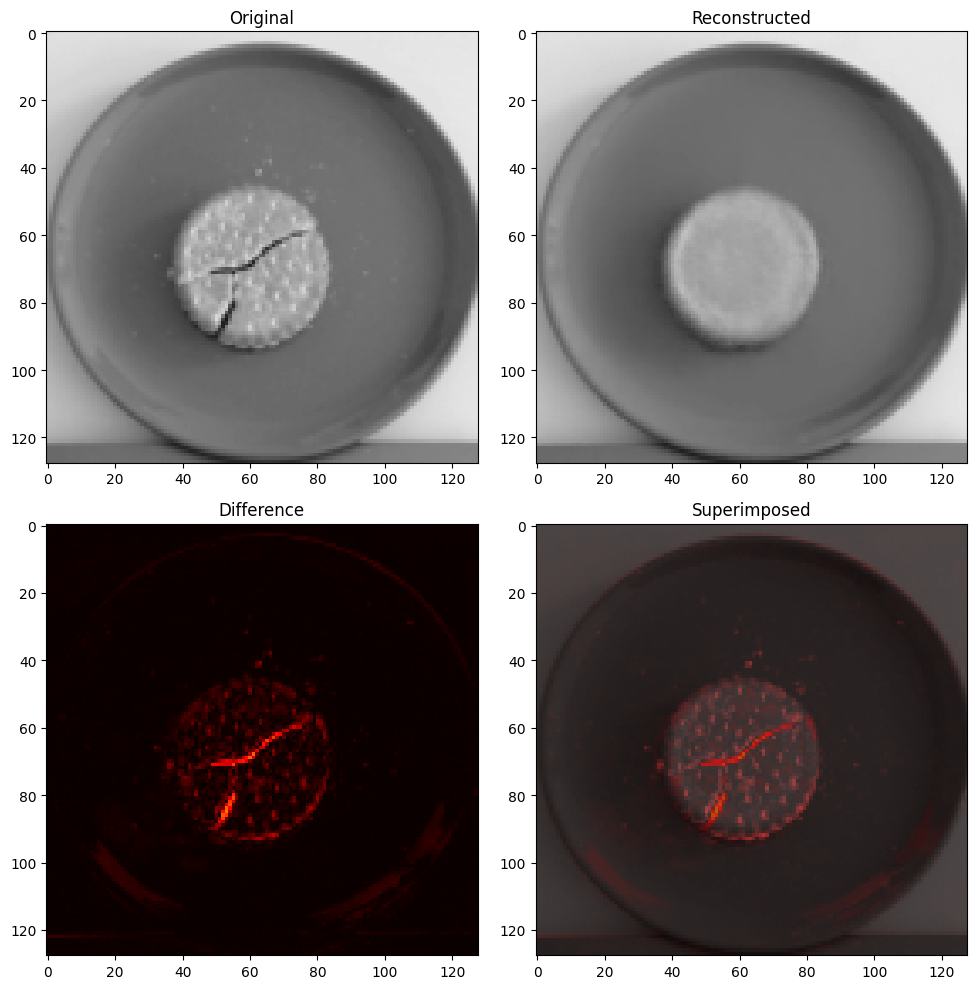

In [5]:
img_original, _ = cast(torch.Tensor, ds_test[70])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original))

img_diff = (img_original - img_reconstr).abs()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

def plot_image(ax, img: torch.Tensor, title: str, cmap: str, alpha=1) -> None:
    ax.imshow(img.movedim(0, -1), cmap=cmap, vmin=0, vmax=1, alpha=alpha)
    ax.set_title(title)

plot_image(axs[0, 0], img_original, title="Original", cmap="gray")
plot_image(axs[0, 1], img_reconstr, title="Reconstructed", cmap="gray")
plot_image(axs[1, 0], img_diff, title="Difference", cmap="hot")
plot_image(axs[1, 1], img_original, title="", cmap="grey")
plot_image(axs[1, 1], img_diff, title="Superimposed", cmap="hot", alpha=0.7)


In [6]:
data: dict[str, Any] = {"set": [], "idx": [], "loss": [], "label": []}

def perform_inference(ds: MVTecAD, set_name: str) -> None:
    loss_fn = torch.nn.L1Loss()

    for idx, (original, label) in enumerate(ds):
        with torch.no_grad():
            original = original.unsqueeze(dim=0)

            reconstructed = model(original)
            loss = loss_fn(reconstructed, original)

            data["set"].append(set_name)
            data["idx"].append(idx)
            data["loss"].append(loss.item())
            data["label"].append(int(label))

perform_inference(ds_train, "train")
perform_inference(ds_test, "test")

df = pd.DataFrame.from_dict(data)

In [7]:
print(df[["set", "loss"]].groupby("set").describe())

        loss                                                              \
       count      mean       std       min       25%       50%       75%   
set                                                                        
test    88.0  0.018738  0.013022  0.006778  0.008246  0.011598  0.028848   
train  176.0  0.007301  0.001315  0.006051  0.006616  0.006898  0.007520   

                 
            max  
set              
test   0.060327  
train  0.015008  


In [8]:
decision_boundary = df[df["set"] == "train"]["loss"].quantile(0.95)
df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

In [9]:
df_test = df[df["set"] == "test"]

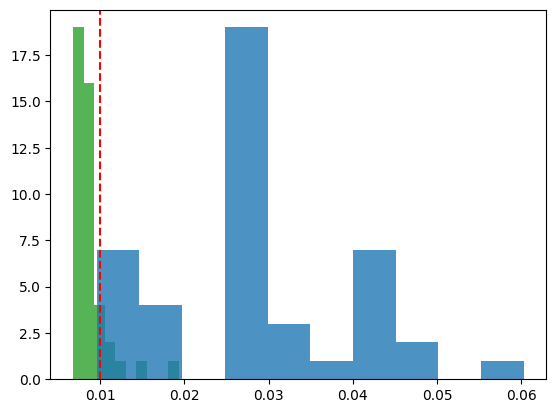

In [10]:
plt.hist(df_test[df_test["label"] == 0]["loss"], color="tab:green", alpha=0.8)
plt.hist(df_test[df_test["label"] == 1]["loss"], color="tab:blue", alpha=0.8)
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [11]:
accuracy = sum(df_test["label"] == df_test["prediction"]) / len(df_test)
accuracy

0.9204545454545454

In [12]:
df.sort_values(by="loss", ascending=False).head(10)

,set,idx,loss,label,prediction
236,test,60,0.060327,1,1
223,test,47,0.046894,1,1
254,test,78,0.045698,1,1
256,test,80,0.043905,1,1
233,test,57,0.043866,1,1
263,test,87,0.043124,1,1
227,test,51,0.043059,1,1
261,test,85,0.042803,1,1
251,test,75,0.041734,1,1
240,test,64,0.041648,1,1
